In [15]:
import math
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import breathDetectionFunctions as bd   
% matplotlib inline

#breathDetection_v1.2

#This breath detection model tries to detect the filling and emptying of the users lungs based on whether the chest sensor is extended more than or less than moving average at a given time.
 

#New this version: 
#- went back to calculating 30s average breath rate

#- Basic rejection algorithm discards breath times shorter than 1.5s and longer than 16s from the calculation of the breath rate. This filter is implemented throug hthe "filterBreaths" function.

#- plotting average of rise and fall breath rate as well (rfmav)

In [16]:
# read in dataset Jill
dset = pd.read_csv('SarahSecondSequence.txt',sep = ' ') # read in dataset
#dset.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
#dset['time'] = dset.index*(1/20) # add timestamp assuming 20 samples / second
#print(dset.head(5))
print(dset.shape[0])
print(dset.shape[0]/600)

13426
22.376666666666665


In [17]:
# pick subsample (just for visualization purposes, so I am not plotting the whole dataset each time.)
d = pd.DataFrame(data = dset[0:dset.shape[0]]) # select which data points; used to be [:8000]
#d = pd.DataFrame(data = dset[0:25000]) # select which data points; used to be [:8000]
d.index = pd.RangeIndex(start = 0, stop = len(d), step = 1) # to measure time from beginning of sub-sample
d.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
d['time'] = d.index*(1/10) # add timestamp assuming 10 samples / second
#print(d.head(5))

d = d.reset_index()

# smoothen sample: subsecond dynamics are removed using exponentially weighted moving average
d['cesm'] = d['chest'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,20)) # smoothen
d['besm'] = d['belly'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,20)) # smoothen

# calculate [6] second moving average and subtract it from smoothened signal to remove long-term drift 
d['cmav'] = d['chest'].rolling(window = 7*20,center = False).mean() - 0 # slight offset because breaths are held for some time.
d['del'] = d['cesm'] - d['cmav']

d['bmav'] = d['belly'].rolling(window = 7*20,center = False).mean() - 0 # slight offset because breaths are held for some time.
d['bdel'] = d['besm'] - d['bmav']

# identify breath phase: distinguishes between above-average and below-average expansion of the sensor. 
d['ph1'] = d['del'].apply(bd.phase) # function: +1 if positive, -1 if negative
d['ph2'] = d['bdel'].apply(bd.phase) # function: +1 if positive, -1 if negative

# take derivative of phase curve: +1 where rise, -1 where fall
d['ph1_slp'] = 0.025*d['ph1'].rolling(window = 2, center = False).apply(bd.slp)
d['ph2_slp'] = 0.025*d['ph2'].rolling(window = 2, center = False).apply(bd.slp)

# store vector with the last [-x:] rise times,
d['riseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph1_slp'][0:int(x/(1/20))]>0].values[-10:])
d['briseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph2_slp'][0:int(x/(1/20))]>0].values[-10:])

# store vector with the last [-x:] fall times
d['fallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph1_slp'][0:int(x/(1/20))]<0].values[-10:])
d['bfallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph2_slp'][0:int(x/(1/20))]<0].values[-10:])

# calculate last [19] breath times based on rise times
d['rbtime'] = d['riseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
d['fbtime'] = d['fallTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on rise times
d['brbtime'] = d['briseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
d['bfbtime'] = d['bfallTimes'].apply(lambda x: x[1:] - x[:-1])

# replace empty entries with NaN
def repNan(x):
    if len(x) == 0:
        return [np.nan]
    else:
        return x
    
# filter all breath measurements that are unrealistically short or long
def filterBreaths(x):
    return [d for d in x if d > 1.5 and d < 24]
    
d['rbtime'] = d['rbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['fbtime'] = d['fbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['brbtime'] = d['brbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['bfbtime'] = d['bfbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)

#def lastEntry(x):
#    if len(x) > 0:
#        return x[-1]
#    else:
#        return np.nan
    
d['rlast'] = d['rbtime'].apply(lambda x: x[-1])
d['flast'] = d['fbtime'].apply(lambda x: x[-1])
d['brlast'] = d['brbtime'].apply(lambda x: x[-1])
d['bflast'] = d['bfbtime'].apply(lambda x: x[-1])

# calculate averaged breath time 
d['rmav'] = d['rlast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x)
d['fmav'] = d['flast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
d['rfmav'] = (d['rmav']+ d['fmav'])/2

d['brmav'] = d['brlast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x)
d['bfmav'] = d['bflast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
d['brfmav'] = (d['brmav']+ d['bfmav'])/2

#Breathing rate averages Chest and Belly
d['cbrfmav'] = d['brfmav']*0.1+d['rfmav']*0.9

# movement data acceleration
d['acc'] = d['ax'].multiply(d['ax']) + d['ay'].multiply(d['ay']) + d['az'].multiply(d['az'])

# movement data angular velocity
d['gyr'] = d['gx'].multiply(d['gx']) + d['gy'].multiply(d['gy']) + d['gz'].multiply(d['gz'])

In [18]:
f = d

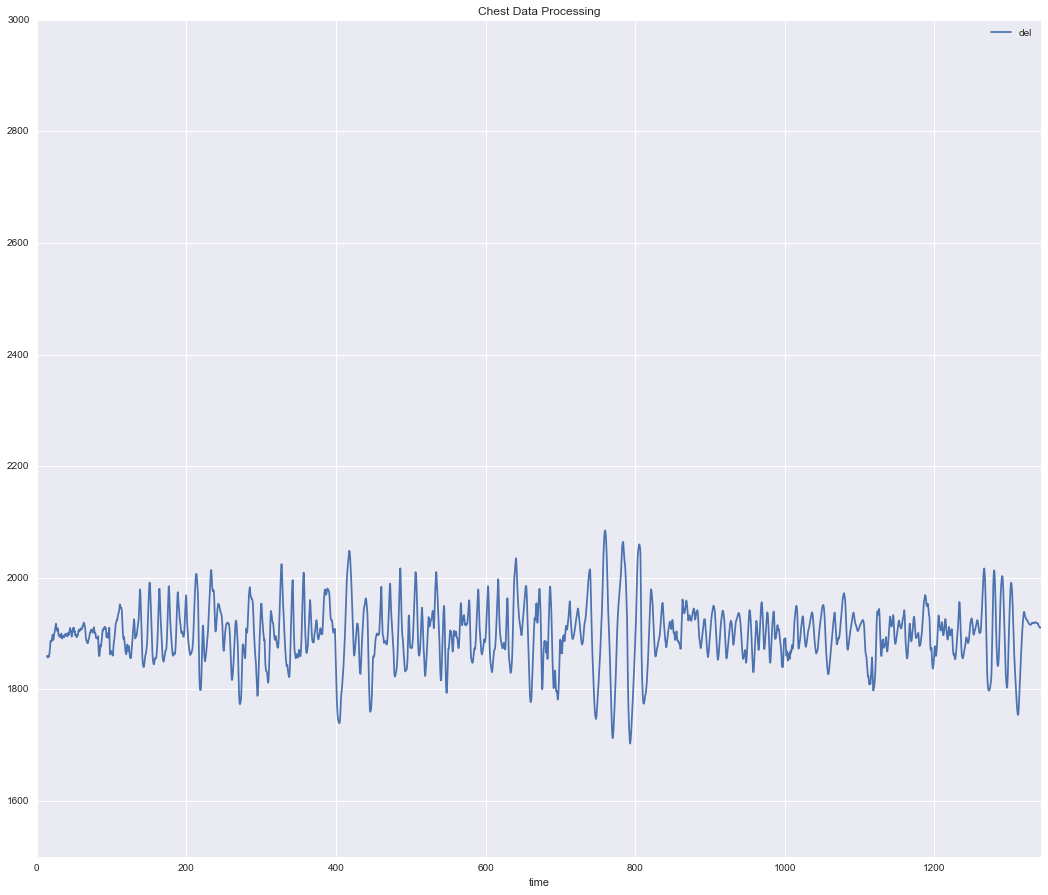

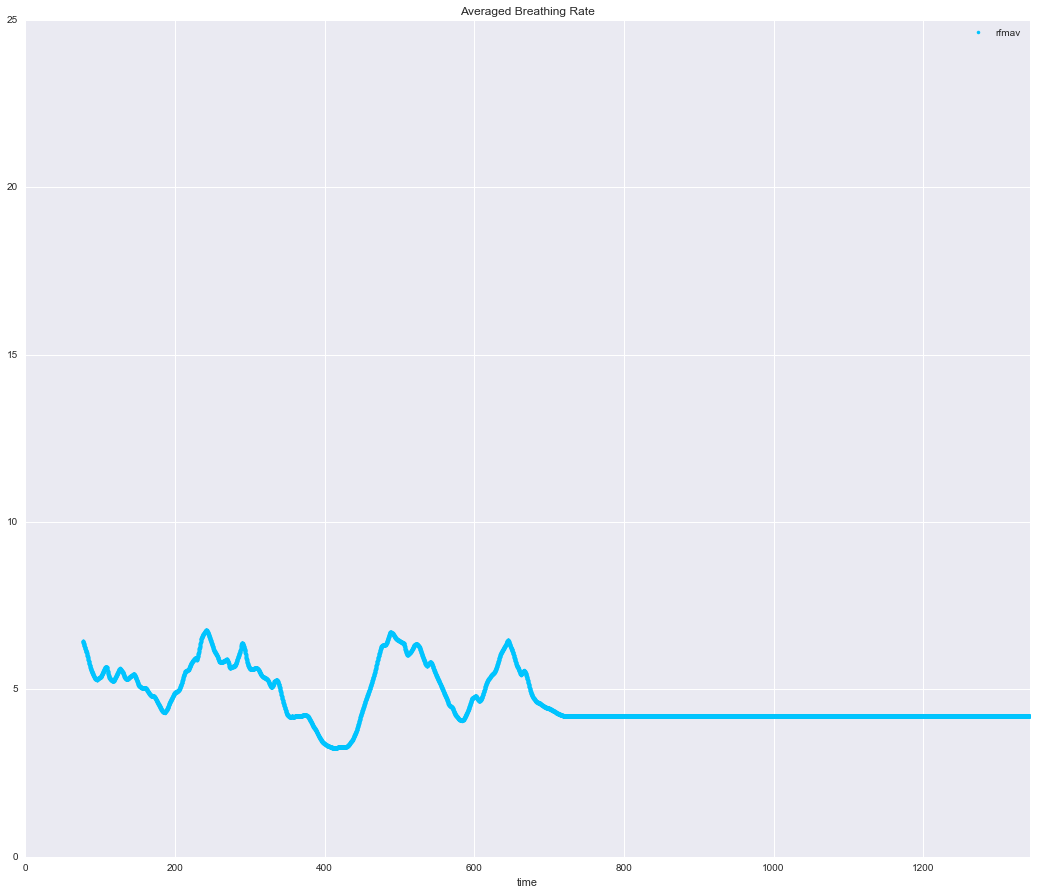

In [19]:
# this is just for plotting data 
g = f
g['cesm'] = f['cesm'] - 500
g['cmav'] = f['cmav'] - 500
g['del'] = f['del'] + 1900
g['b1'] = 1900
g['ph1'] = 100*f['ph1'] + 2800
g['b2'] = 1600
g['ph2'] = 100*f['ph2'] + 2200
#g.plot(x = 'time',y = ['chest','belly','cesm','cmav','del','b1','ph1','b2'],figsize = (18,15),title = 'Chest Data Processing')
g.plot(style=['-'],x = 'time',y = ['del'],figsize = (18,15), ylim = (1500,3000), title = 'Chest Data Processing')
#g.plot(x = 'time',y = ['chest','belly','ph1','ph2'],figsize = (18,15),title = 'Breathing Raw Data')
#d.plot(x = 'time',y = ['rlast','flast'], figsize = (18,3), title = 'Length of last detected breath, based on successive rise (r) and fall (f) times.')
d.plot(style=['.'], x = 'time',y = ['rfmav'], color = '#00C4FF', ylim = (0,25), figsize = (18,15), title = 'Averaged Breathing Rate')
#d.plot(x = 'time',y = 'acc',figsize = (18,3),title = 'Accelerometer Data')
#d.plot(x = 'time',y = 'gyr',figsize = (18,3),title = 'Gyroscope Data')

Note that all moving averages are calculated using only data available at the time, which causes the corresponding curves to lag behind (compare moving averages of breath times to real-time breath times above). 

In [20]:
print(d[::1000]) # every thousandth line of the processed dataset

       index  chest  belly   ax   ay   az    gx    gy    gz    time  ...   \
0          0   2158   1953  472  -31  329  1102  -618 -1685     0.0  ...    
1000    1000   2066   1841  -72  551  251   203 -4248  4213   100.0  ...    
2000    2000   2172   1887   41  560   31 -1137 -2204   380   200.0  ...    
3000    3000   2246   1861   88  542  -50  -475   -70  -142   300.0  ...    
4000    4000   2072   1890   48   19  643 -1888  -246    47   400.0  ...    
5000    5000   1996   1868   31  550  -17   137   -29  -115   500.0  ...    
6000    6000   2156   1776  127  305  550  7074  -150  -743   600.0  ...    
7000    7000   2026   1766    8  120 -392   224 -2420  -354   700.0  ...    
8000    8000   2056   1876   31   28 -365   365  -239    -4   800.0  ...    
9000    9000   2236   2001   19  -64 -356   107   -43   -34   900.0  ...    
10000  10000   2180   1832   51   71 -365   159  -245   -18  1000.0  ...    
11000  11000   2251   1859   38   73 -362   219  -183   -28  1100.0  ...    

In [21]:
d.head(6000)

index  chest  belly   ax   ay   az     gx     gy     gz   time  ...   \
0         0   2158   1953  472  -31  329   1102   -618  -1685    0.0  ...    
1         1   2160   1958  504  -31  352    536  -4705  -4031    0.1  ...    
2         2   2166   1964  526   89  177  -6092  -2005  -7215    0.2  ...    
3         3   2168   1966  600  -52  224  -1798   -189   4573    0.3  ...    
4         4   2171   1970  552  191   86    119  -1281  -4327    0.4  ...    
5         5   2167   1969  414  172  227   7591 -30746 -21741    0.5  ...    
6         6   2166   1963  331  408   35   7730 -25658 -20286    0.6  ...    
7         7   2168   1962  167  384 -200  -4381  -7169 -11005    0.7  ...    
8         8   2166   1950  102  356 -170  11307  -9157  -1088    0.8  ...    
9         9   2158   1957  131  326 -208   3675  -5904  -3674    0.9  ...    
10       10   2157   1956   71  284 -344   6431  -3174  -2101    1.0  ...    
11       11   2162   1953   94  203 -344   2309   9700   2277    1.1  ...    
12       12   2170   1956  120  152 -308   6341   7311   5783    1.2  ...    
13       13   2158   1962  152   81 -305  18720   -490    734    1.3  ...    
14       14   2162   1958  228   35 -314  -9559   5223   4289    1.4  ...    
15       15   2161   1959  200   63 -250   1707     -8   2727    1.5  ...    
16       16   2168   1958  208   23 -329   2040   -759  -1500    1.6  ...    
17       17   2150   1959  156   56 -324   4529   2414  -2426    1.7  ...    
18       18   2154   1957  231  -50 -365   7354  -1737     -1    1.8  ...    
19       19   2154   1960  204   14 -313   9435   5588   4519    1.9  ...    
20       20   2153   1963  248  -77 -296    621   2616   2895    2.0  ...    
21       21   2159   1962  251 -121 -360   3166    428    393    2.1  ...    
22       22   2167   1969  251  -92 -304   -922  -1295  -1153    2.2  ...    
23       23   2176   1971  264  -57 -311    690    403  -2176    2.3  ...    
24       24   2178   1974  284  -77 -322  -2155   -327  -3369    2.4  ...    
25       25   2177   1971  260  -45 -332   1387    578   -175    2.5  ...    
26       26   2183   1972  264  -64 -311   2479    476   -279    2.6  ...    
27       27   2185   1977  240  -25 -306   -161   -347  -1344    2.7  ...    
28       28   2180   1975  236  -31 -316  -2030   -672   -961    2.8  ...    
29       29   2170   1974  211   35 -282  -1908  -1022   -673    2.9  ...    
...     ...    ...    ...  ...  ...  ...    ...    ...    ...    ...  ...    
5970   5970   2122   1813  488 -223  129    192   1852    867  597.0  ...    
5971   5971   2128   1815  487 -232  137    290   2173   1139  597.1  ...    
5972   5972   2131   1812  483 -236  148    368   2517   1423  597.2  ...    
5973   5973   2139   1812  481 -250  172    709   3398   1871  597.3  ...    
5974   5974   2137   1805  462 -264  211   2270   4868   2315  597.4  ...    
5975   5975   2137   1813  440 -272  240   2165   3446   1838  597.5  ...    
5976   5976   2140   1827  446 -274  252   1708   2253   1300  597.6  ...    
5977   5977   2137   1831  440 -285  291   1538   3277   1289  597.7  ...    
5978   5978   2128   1841  411 -281  319   1263   3521   1287  597.8  ...    
5979   5979   2132   1847  391 -281  351   1144   2782   1449  597.9  ...    
5980   5980   2128   1856  388 -281  337   1015   2367   1443  598.0  ...    
5981   5981   2128   1852  375 -297  383    755   3470   1367  598.1  ...    
5982   5982   2119   1846  355 -311  412   1198   3420   1125  598.2  ...    
5983   5983   2108   1846  328 -319  438   1939   3830   1108  598.3  ...    
5984   5984   2104   1847  307 -306  470   2542   3372    734  598.4  ...    
5985   5985   2095   1839  283 -296  480   3365   2195    593  598.5  ...    
5986   5986   2089   1838  280 -269  496   3717   1935    323  598.6  ...    
5987   5987   2089   1840  255 -247  520   3797   2131    100  598.7  ...    
5988   5988   2090   1840  246 -228  551   4047   2089    221  598.8  ...    
5989   5989   2095   1849  2